In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import norm
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

G = nx.read_gml("galFiltered.gml").to_undirected()
G = max(nx.connected_component_subgraphs(G), key=len)

labels = nx.get_node_attributes(G, "label")

genes_in_network = labels.values()

expression_data = pd.read_csv("galExpData.csv")

genes_in_expression_data = expression_data.loc[:,["GENE"]].as_matrix().flatten()

genes_in_network = [gene for gene in genes_in_network if gene in genes_in_expression_data]

# subnetwork that is labelled
nodes_of_interest = [k for k, v in nx.get_node_attributes(G, "label").items() if v in genes_in_network]
G = G.subgraph(nodes_of_interest)

p_values = expression_data.set_index("GENE").loc[genes_in_network,["gal1RGsig", "gal4RGsig", "gal80Rsig"]].as_matrix()

In [2]:
z_scores = norm.ppf(1 - p_values)

In [3]:
eps = 1e-8

z_scores -= (z_scores.min(axis=0) + eps)

In [4]:
z_scores = z_scores[:, 0]

A = np.array(nx.adjacency_matrix(G).todense())

A = A * z_scores[:, None]

In [10]:
idx = z_scores.argsort()[::-1]
A[idx][:,idx][0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [11]:
# A = Z * A

# G = nx.from_numpy_matrix(A)
# G = max(nx.connected_component_subgraphs(G), key=len)

# labels = {k: v for k,v in labels.items() if k in G.nodes()}
# nx.set_node_attributes(G, "label", labels)

N = nx.number_of_nodes(G)

# A = np.array(nx.adjacency_matrix(G).todense())
D = A.sum(axis=0)

W = (np.identity(N) + A.dot(np.diag(1./D))) / 2

def matrix_multiply(M, n):
    if n == 0:
        return np.identity(M.shape[0])
    if n % 2 == 0:
        m = matrix_multiply(M, n/2).dot(matrix_multiply(M, n/2))
    else: m = M.dot(matrix_multiply(M, n-1))
    m[m < 0] = 0
    return m / m.sum(axis=0)

In [12]:
n = 5

# targets = matrix_multiply(W, n=50)
targets = matrix_multiply(W, n=n).transpose()

D_n = targets.sum(axis=0)

I = np.identity(N)

# I = ((I - I.mean(axis=0)) / I.std(axis=0))

# from itertools import product

# list_of_pairs = map(list, zip(*list(product(I, repeat=2))))
# nodes_1 = np.array(list_of_pairs[0])
# nodes_2 = np.array(list_of_pairs[1])

# target_p_values = targets.reshape((np.prod(targets.shape),), order="C")

In [13]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Lambda, Merge
from keras.layers.merge import Dot
from keras.regularizers import l2

import keras.backend as K

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GT 650M (0000:01:00.0)


In [8]:
# single embedder
# x = Input(shape=(N,))
# y = Dense(128, activation="tanh")(x)
# y = Dropout(0.5)(y)
# y = Dense(64, activation="tanh")(y)
# y = Dropout(0.5)(y)
# embedding = Dense(2, activation="linear")(y)

# embedder = Model(x, embedding)

In [9]:
# hyperbolic embedder for r and theta
# x = Input(shape=(N,))
# y = Dense(128, activation="tanh", kernel_regularizer=l2())(x)
# y = Dropout(0.5)(y)
# y = Dense(64, activation="tanh", kernel_regularizer=l2())(y)
# y = Dropout(0.5)(y)
# r = Dense(1, activation="linear", kernel_regularizer=l2())(y)
# theta = Dense(1, activation="linear", kernel_regularizer=l2())(y)

# hyperbolic_embedder = Model(x, [r, theta])

In [14]:
num_samples = 10

In [15]:
def cosh(x):
    return (K.exp(x) + K.exp(-x)) / 2

def sinh(x):
    return (K.exp(x) - K.exp(-x)) / 2

def arccosh(x):
    return K.log(x + K.sqrt(x ** 2 - 1) )

def hyperbolic_cosine_softmax(args):
    
    theta1, theta2 = args
    
    # exponentiate to compute probability
    cos_delta = K.cos(K.abs(theta1 - theta2))
    
    softmax = K.softmax(K.transpose(cos_delta))
    
    return K.concatenate([softmax for i in range(num_samples)], axis=0)

def hyperbolic_multi_cosine_softmax(args):
    
    theta1 = args[0]
    thetas = args[1:]
    
    pi = K.constant(np.pi)
    
    cosine_sim = K.concatenate([K.cos(K.abs(theta1 - theta)) for theta in thetas])

    return K.softmax(cosine_sim)

# def hyperbolic_r_softmax(args):
    
#     r1, r2 = args
    
def hyperbolic_distance(r1, theta1, r2, theta2):
    
    # compute hyperbolic distance 
    pi = K.constant(np.pi)
    delta = pi - K.abs(pi - K.abs(theta1 - theta2))
    d = cosh(2 * r1) * cosh(2 * r2) - sinh(2 * r1) * sinh(2 * r2) * K.cos(delta)
    d = K.maximum(1 + K.epsilon(), d)
    d = 0.5 * arccosh(d)
    
    return d

#     return r1 + r2 + K.log(delta / 2)
    
#     x1 = K.concatenate([r1 * K.cos(theta1), r1 * K.sin(theta1)])
#     x2 = K.concatenate([r2 * K.cos(theta2), r2 * K.sin(theta2)])
#     d = K.sum(K.square(x2 - x1), axis=1)
    
#     return K.reshape(d, shape=(-1, 1))
    

def hyperbolic_softmax(args):
    
    r1, theta1, r2, theta2 = args
    
    d = - hyperbolic_distance(r1, theta1, r2, theta2)
    
    # exponentiate to compute probability
#     exp_d = K.exp(d)
    
#     return exp_d / exp_d.sum()
    softmax = K.softmax(K.transpose(d))
    return K.concatenate([softmax for i in range(num_samples)], axis=0)

def hyperbolic_multi_softmax(args):
    
#     r1 = args[0][:,0]
#     theta1 = args[0][:,1]
    r1, theta1 = args[:2]
    
#     print r1.eval()
#     print theta1.eval()
    
#     for r2, theta2 in zip(args[2::2], args[3::2]):
#         print hyperbolic_distance(r1, theta1, r2, theta2).eval()
#         print r2.eval()
#         print theta2.eval()
#         print
    
    minus_d = - K.concatenate([hyperbolic_distance(r1, theta1, 
#                             r2=p[:,0], theta2=p[:,1])
#                            for p in args[1:]]))
                        r2, theta2) for r2, theta2 in zip(args[2::2], args[3::2])])
    
#     print minus_d.eval()
    
    return K.softmax(minus_d)
    

# def softmax(args):
    
#     m1, m2 = args
    
#     m1 = K.l2_normalize(m1, axis=1)
#     m2 = K.l2_normalize(m2, axis=1)
    
#     exp = K.exp(K.batch_dot(m1, m2, axes=1))
    
#     return exp / exp.sum()

In [ ]:
# batch_size = N

In [ ]:
# r1 = K.constant(np.array([[3],[5],[6]]))
# theta1 = K.constant(np.array([[6],[1],[6]]))
# r2 = K.constant(np.array([[2],[1],[4]]))
# theta2 = K.constant(np.array([[3],[5],[6]]))
# r3 = K.constant(np.array([[2],[5],[4]]))
# theta3 = K.constant(np.array([[7],[5],[6]]))
# r4 = K.constant(np.array([[2],[1],[7]]))
# theta4 = K.constant(np.array([[7],[5],[6]]))

In [ ]:
# hyperbolic_softmax([r1, theta1, r2, theta2]).eval().shape

In [ ]:
# hyperbolic_multi_softmax([r1, theta1, r1, theta1, r2, theta2, r3, theta3, r4, theta4]).eval().sum(axis=1)

In [ ]:
# # overall model
# x1 = Input(shape=(N,))
# x2 = Input(shape=(N,))

# embedding1 = embedder(x1)
# embedding2 = embedder(x2)

# probabilities = Lambda(softmax, output_shape=(1,))([embedding1, embedding2])

In [ ]:
# theta hyperbolic model
# overall model
# x1 = Input(shape=(N,))
# x2 = Input(shape=(N,))

# theta1 = theta_embedder(x1)
# theta2 = theta_embedder(x2)

# probabilities = Lambda(hyperbolic_cosine_softmax, output_shape=(1,))([theta1, theta2])

In [ ]:
# N = 10
# N = I.shape[0]
# parallel_inputs = [I[:N,:N]] + [np.array([I[i,:N]] * N) for i in range(N)]
# parallel_targets = targets[:N, :N]

In [ ]:
# from keras.objectives import mean_squared_error

In [ ]:
# def popularity_loss(y_true, y_pred):
    
#     pred_sort = K.np.argsort(y_pred)
    
#     return mean_squared_error(y_true, pred_sort)

In [16]:
reg = 1e-5

# model to compute radius
in_r = Input(shape=(N,))
out_r = Dense(128, activation="tanh", kernel_regularizer=l2(reg), bias_regularizer=l2(reg))(in_r)
out_r = Dropout(0.5)(out_r)
out_r = Dense(64, activation="tanh", kernel_regularizer=l2(reg), bias_regularizer=l2(reg))(out_r)
out_r = Dropout(0.5)(out_r)
out_r = Dense(1, activity_regularizer=l2(reg), kernel_regularizer=l2(reg), bias_regularizer=l2(reg))(out_r)

r_embedder = Model(in_r, out_r)

# r_embedder.compile(loss="mse", optimizer=sgd)

# model to compute theta
in_theta = Input(shape=(N,))
out_theta = Dense(128, activation="tanh", kernel_regularizer=l2(reg), bias_regularizer=l2(reg))(in_theta)
out_theta = Dropout(0.5)(out_theta)
out_theta = Dense(64, activation="tanh", kernel_regularizer=l2(reg), bias_regularizer=l2(reg))(out_theta)
out_theta = Dropout(0.5)(out_theta)
out_theta = Dense(1, kernel_regularizer=l2(reg), bias_regularizer=l2(reg))(out_theta)

theta_embedder = Model(in_theta, out_theta)

# theta_embedder.compile(loss="mse", optimizer=sgd)

# # overall embedder
hyperbolic_embedder_input = Input(shape=(N,))
hyperbolic_embedder = Model(hyperbolic_embedder_input, 
                            [r_embedder(hyperbolic_embedder_input), theta_embedder(hyperbolic_embedder_input)])

# hyperbolic_embedder.compile(loss="mse", optimizer=sgd)

In [18]:
# hyperbolic model
# overall model
x1 = Input(shape=(N,))
x2 = Input(shape=(N,))

r1, theta1 = hyperbolic_embedder(x1)
r2, theta2 = hyperbolic_embedder(x2)

probabilities = Lambda(hyperbolic_softmax, output_shape=(num_samples,))([r1, theta1, r2, theta2])

In [19]:
model = Model([x1, x2], probabilities)

In [20]:
model.compile(optimizer="adam", loss=["kld"])

In [22]:
a = np.array([1,2,3])

In [23]:
np.delete(a, 2)

array([1, 2])

In [25]:
def generator(num_samples):
    
    while True:
        
        destination_node = np.random.randint(N)
        
        in_1 = np.array([I[destination_node] for i in range(num_samples)])
        
        p = np.random.permutation(N)
        
        in_2 = I[p[p!=destination_node][:num_samples]]
        
        target_distribution = np.array([targets[destination_node][p[:num_samples]] for i in range(num_samples)])
        
#         popularity_sort = weighted_sorted_nodes[p]
        
        yield [in_1, in_2], target_distribution

In [26]:
model.fit_generator(generator(num_samples), steps_per_epoch=100, epochs=100, verbose=False)

In [35]:
k = 0
K = np.zeros(A.shape)
M = W
while (M == 0).any():
    
    M = M.dot(W)
    
    k += 1
    
print k

26


In [36]:
targets = M.transpose()

In [ ]:
# model.fit([nodes_1, nodes_2], target_p_values, batch_size=N, epochs=10, shuffle=False)

In [37]:
# import sys
# sys.setrecursionlimit(10000)

In [38]:
# # parallel theta model
# input_layers = [Input(shape=(N,)) for i in range(N + 1)]
# theta_layer = [theta_embedder(inp) for inp in input_layers]
# probabilities = Lambda(hyperbolic_multi_cosine_softmax, output_shape=(N,))(theta_layer)

# theta_model = Model(input_layers, probabilities)

# theta_model.compile(optimizer="adam", loss="kld")

In [39]:
# theta_model.fit_generator(generator, steps_per_epoch=10, epochs=10)

In [40]:
# theta_model.fit(parallel_inputs, parallel_targets, epochs=10, verbose=True)

In [41]:
# # N parallel models 
# reg = 1e-5
# # R
# r_inputs = [Input(shape=(N,)) for i in range(N + 1)]
# r_hiddens = [Dense(128, activation="tanh", kernel_regularizer=l2(reg), bias_regularizer=l2(reg))(x) for x in r_inputs]
# r_outputs = [Dense(1, activity_regularizer=l2(reg), kernel_regularizer=l2(reg), bias_regularizer=l2(reg))(x) for x in r_hiddens]

# r_embedders = [Model(x, y) for x, y in zip(r_inputs, r_outputs)]

# # theta
# theta_inputs = [Input(shape=(N,)) for i in range(N + 1)]
# theta_hiddens = [Dense(128, activation="tanh", kernel_regularizer=l2(reg), bias_regularizer=l2(reg))(x) for x in theta_inputs]
# theta_outputs = [Dense(1, kernel_regularizer=l2(reg), bias_regularizer=l2(reg))(x) for x in theta_hiddens]

# theta_embedders = [Model(x, y) for x, y in zip(theta_inputs, theta_outputs)]

# # overall hyperbolic embedder
# hyperbolic_inputs = [Input(shape=(N,)) for i in range(N + 1)]
# hyperbolic_embedders = [Model(x, [r(x), theta(x)]) for x, r, theta in zip(hyperbolic_inputs, r_embedders, theta_embedders)]

In [42]:
# # parallel theta and r model
# input_layers = [Input(shape=(N,)) for i in range(N + 1)]
# r_theta_pairs = sum([hyperbolic_embedder(inp) for inp in input_layers], [])
# # r_theta_pairs = sum([y(x) for x, y in zip(input_layers, hyperbolic_embedders)], [])
# probabilities = Lambda(hyperbolic_multi_softmax, output_shape=(N,))(r_theta_pairs)

In [43]:
# # permute targets
# def generate_input_target(steps_per_epoch):
    
#     while True:
        
#         # destination nodes
#         destination_nodes = np.random.randint(N, size=(steps_per_epoch,))

#         # random position of destination node in inputs
# #         positions = np.random.randint(N, size=(steps_per_epoch,))

#         # permuation of source nodes
#         permutations = np.array([np.random.permutation(N) for i in range(steps_per_epoch)])

#         # list of input arrays
# #         inputs = [I[i] for i in p[:pos]] + [I[n]] + [I[i] for i in p[pos:]]
#         inputs = [I[positions]] + [I[permutations[:,i]] for i in range(N)]
        
#         # target distribution
#         target = np.array([targets[n][p] for n, p in zip(destination_nodes, permutations)])

#         # yield tuple of x, y pairs as required
#         yield inputs, target

In [44]:
# parallel_model = Model(input_layers, probabilities)

In [45]:
# parallel_model.compile(loss="kld", optimizer="adam")

In [46]:
# parallel_model.fit_generator(generate_input_target, steps_per_epoch=10, epochs=10)

In [101]:
# parallel_model.fit(parallel_inputs, parallel_targets, epochs=1, verbose=True, batch_size=1)

In [47]:
# R = r_embedder.predict(I[:N, :N]).flatten()

In [48]:
# theta_predictions = theta_embedder.predict(I[:N, :N]).flatten()

In [105]:
# X = embedder.predict(I)

In [49]:
# sorted_nodes = np.array(nx.degree(G).values()).argsort()[::-1]

In [50]:
# sorted_nodes

In [51]:
# weighted_sorted_nodes = D_n[:N].argsort()[::-1]

In [52]:
# weighted_sorted_nodes

In [53]:
# mean_weighted_sorted_nodes = (D_n / np.array(nx.degree(G).values())).argsort()[::-1]

In [54]:
# mean_weighted_sorted_nodes

In [55]:
# beta = 1.0 / (2 - 1)
# R = 2 * beta * np.log(range(1, N + 1)) + 2 * (1 - beta) * np.log(N + 1)
# R[weighted_sorted_nodes] = R

In [28]:
R, theta_predictions = hyperbolic_embedder.predict(I)

R = R.flatten()
theta_predictions = theta_predictions.flatten()

In [29]:
def hyperbolic_distance_numpy(r1, theta1, r2, theta2):
    
    delta = np.pi - np.abs(np.pi - np.abs(theta1 - theta2))
    d = np.cosh(2 * r1) * np.cosh(2 * r2) - np.sinh(2 * r1) * np.sinh(2 * r2) * np.cos(delta)
    d = np.maximum(1.0, d)
    d = 0.5 * np.arccosh(d)
    
    if np.array_equal(r1, r2) and np.array_equal(theta1, theta2):
        d = 0
    
    return d

D = np.array([[hyperbolic_distance_numpy(r1, theta1, r2, theta2) for r2, theta2 in zip(R, theta_predictions)]
             for r1, theta1 in zip(R, theta_predictions)])

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(metric="precomputed", eps=0.5)

dbscan.fit(D)

c = dbscan.labels_

In [40]:
X = np.column_stack([R * np.cos(theta_predictions), R * np.sin(theta_predictions)]) 

In [27]:
# from sklearn.cluster import KMeans

In [28]:
# kmeans = KMeans(n_clusters=8)
# kmeans.fit(X)

In [29]:
# c = kmeans.labels_

In [28]:
# best_module = np.genfromtxt("best_active_module.txt", dtype=str)
# c = ["r" if v in best_module else "b" for v in nx.get_node_attributes(G, "label").values()]

In [31]:
# c = ["r" if z else "b" for z in z_values > np.percentile(z_values, 50).flatten()]

In [32]:
# plt.figure(figsize=(15, 15))
# plt.plot(model.history.history["loss"])

In [63]:
for i in range(c.max()):
    H = G.subgraph(np.where(c == i)[0])
    print nx.number_connected_components(H)

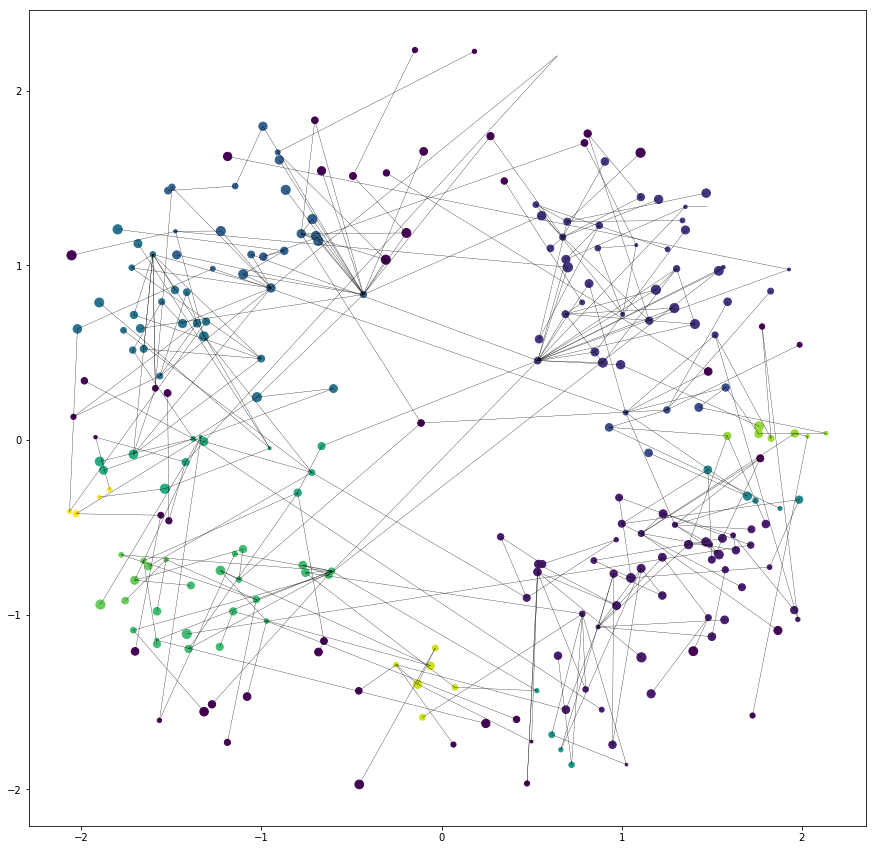

In [42]:
plt.figure(figsize=(15, 15))
l = 15
# for label, i, j in zip(z_values, X[:l, 0], X[:l, 1]):
#     plt.annotate(
#         label,
#         xy=(i, j), xytext=(-20, 20),
#         textcoords='offset points', ha='right', va='bottom',
#         bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
#         arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

nodes = np.array(G.nodes())
for n1, n2 in G.edges():
    i, = np.where(nodes == n1)
    j, = np.where(nodes == n2)
    plt.plot(X[(i, j), 0], X[(i, j), 1], c="k", 
             linewidth = 0.3)

plt.scatter(X[:,0], X[:,1], c = c, s = 10 * z_scores)

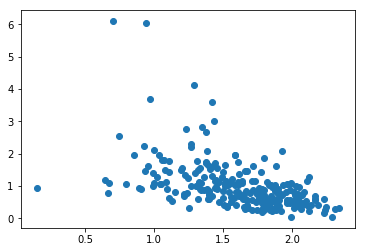

In [43]:
plt.scatter(np.abs(R), targets.sum(axis=0))